In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaoutaraissaoui","key":"5603cd7ddb70daca0cbebad9b12b7297"}'}

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:03<00:00, 110MB/s] 
100% 346M/346M [00:03<00:00, 107MB/s]


In [ ]:
from zipfile import ZipFile
file_name="intel-image-classification.zip"

with ZipFile(file_name, 'r') as zip :
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import cv2
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plot
from random import randint
import keras.optimizers as Optimizer
import keras.utils as Utils
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.gridspec as gridspec

In [ ]:
    #créer une fonction pour extraire les images des dossiers
    def get_images(directory):
      Images = []
      Labels = []  # 0 pour Building , 1 pour forest, 2 pour glacier, 3 pour mountain, 4 pour Sea , 5 pour Street
      label = 0
      for labels in os.listdir(directory): #chaque label est présenté comme nom de dossier contenant nos images.
      #os.listdir(path) : Cette méthode retourne une liste contenant les noms des entrées du répertoire donné dans le path.
        if labels == 'glacier': #dans le dossier Glacier les images obtiennent le libellé de classe 2
          label = 2
        elif labels == 'sea':
          label = 4
        elif labels == 'buildings':
          label = 0
        elif labels == 'forest':
          label = 1
        elif labels == 'street':
          label = 5
        elif labels == 'mountain':
          label = 3
        for image_file in os.listdir(directory+labels): #Extraction du nom de fichier de l'image du dossier de chaque label de classe
          image = cv2.imread(directory+labels+r'/'+image_file)  #Reading the image (OpenCV)
          '''OpenCV est une bibliothèque graphique libre, initialement développée par Intel, 
          spécialisée dans le traitement d'images en temps réel. c'est une bibliothèque de Python conçue pour résoudre les problèmes de computer vision'''
          '''La méthode cv2.imread () charge une image à partir du fichier spécifié. 
          Si l'image ne peut pas être lue (en raison d'un fichier manquant, d'autorisations incorrectes, 
          d'un format non pris en charge ou non valide), cette méthode renvoie une matrice vide.'''
          image = cv2.resize(image,(150,150)) #Redimensionner l'image, certaines images sont de tailles différentes. (Le redimensionnement est très important)
          Images.append(image) #on ajoute chaque image parcouru dans la liste des images
          Labels.append(label) #on ajoute egalement pour chaque image parcouru son label correspondant 
      return shuffle(Images,Labels,random_state=817328462) #Mélanger le dataset.
      '''En mélangeant nos données, nous nous assurons que chaque point de données crée un changement «indépendant» sur le modèle, 
       sans être biaisé par les mêmes points avant eux. Le shuffle des données sert à réduire la variance et à s'assurer que les modèles restent généraux et moins overfited.
       Nous avons mélangé nos données car elles sont triées par classe. Ici, nous voudrons mélanger pour nous assurer que nos ensembles de train / test / validation sont représentatifs de la distribution globale des données.'''
#on crée une fonction qui retourne la valeur de chaque clé du dictionnaire des labels créé
def get_classlabel(class_code):
  labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
  return labels[class_code]

In [ ]:
Images, Labels = get_images('/content/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels) ##converting the list of labels to numpy array.

In [ ]:
print("Shape of Images:",Images.shape) 
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


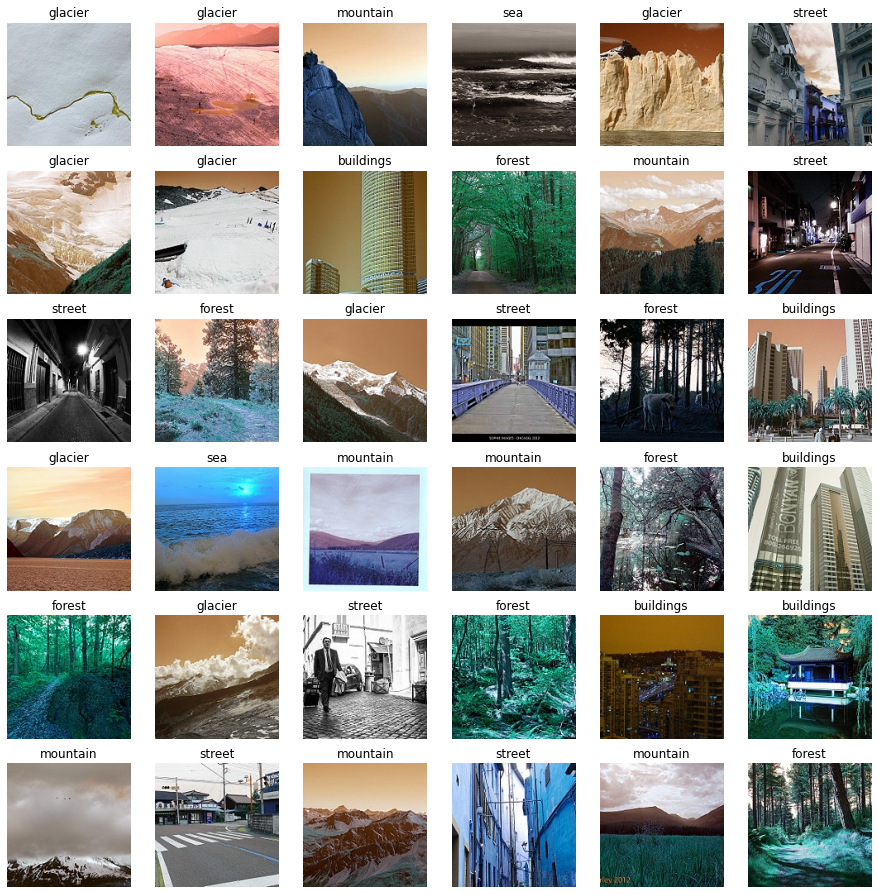

In [ ]:
#Regardons quelques images aléatoires de notre ensemble de dataset
f,ax = plot.subplots(6,6) #présenter sur une même zone graphique plusieurs tracés de résultats (6 images par ligne et 6 par colonne)
f.subplots_adjust(1,0,3,3) #Ajustez la disposition de l'ensemble des images.
for i in range(0,6,1): #parcourir les lignes
    for j in range(0,6,1): #parcourir les colonnes
        rnd_number = randint(0,len(Images)) #on prend une image aléatoire (son indice) de la liste des images
        ax[i,j].imshow(Images[rnd_number]) #on affiche dans la position (i,j) l'image prise
        ax[i,j].set_title(get_classlabel(Labels[rnd_number])) #on définit le titre de l'image comme label
        ax[i,j].axis('off') #masquer les valeurs sur les axes

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/seg_train/seg_train",target_size=(150,150))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/seg_test/seg_test", target_size=(150,150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same', input_shape=(150,150,3)))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001),  activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.001), activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization(momentum = 0.9))
vgg_16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
vgg_16_model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
vgg_16_model.add(Dense(6, activation='softmax'))

In [ ]:
vgg_16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_156 (Bat (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_157 (Bat (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_158 (Bat (None, 75, 75, 128)     

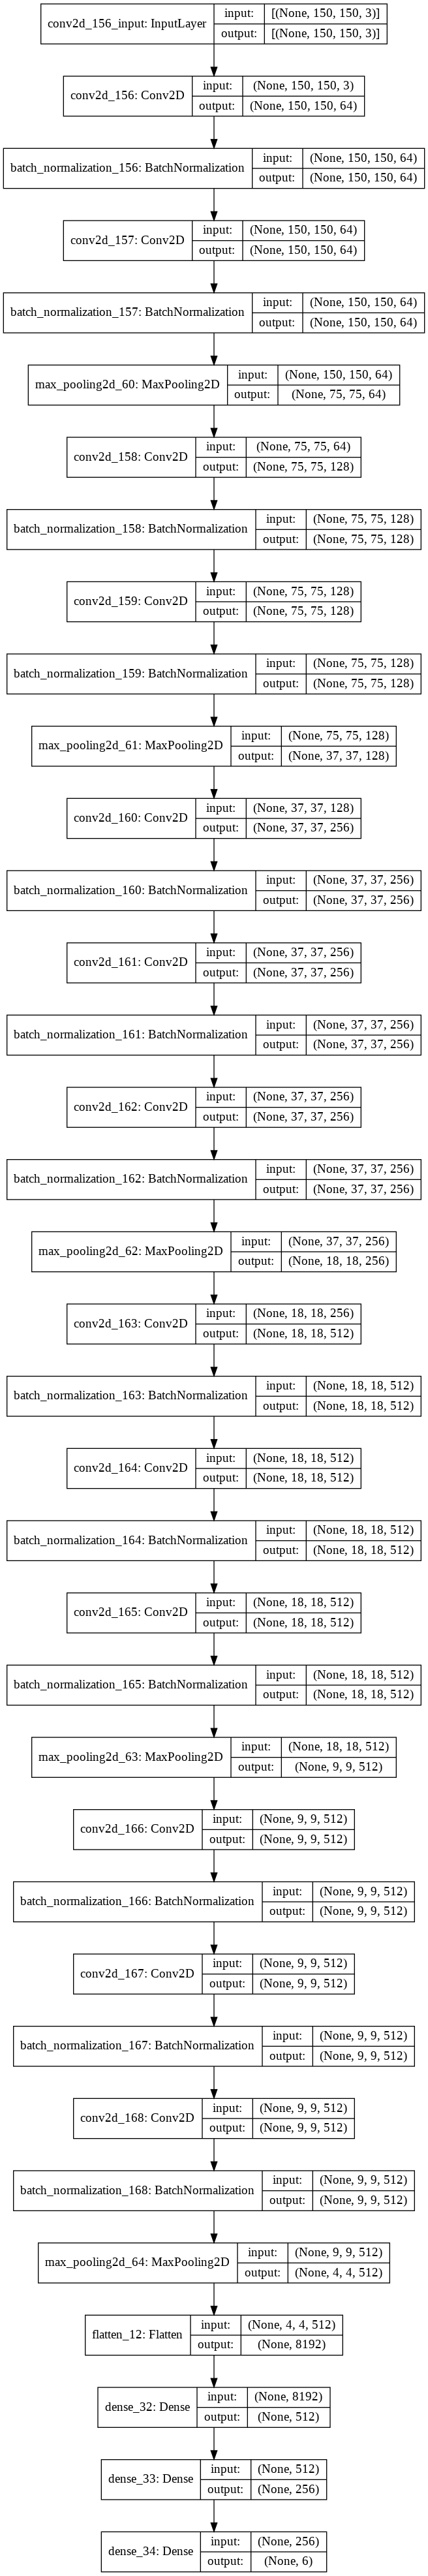

In [ ]:
vgg_16_model.summary()
Utils.plot_model(vgg_16_model,to_file='model.png',show_shapes=True)

In [ ]:
vgg_16_model.fit_generator(generator = traindata, steps_per_epoch = 20, validation_data = testdata,validation_steps = 10, epochs = 50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 8s 304ms/step - loss: 10.8367 - accuracy: 0.2553 - val_loss: 11.9089 - val_accuracy: 0.3000
Epoch 2/50
20/20 [==============================] - 6s 289ms/step - loss: 7.2821 - accuracy: 0.4659 - val_loss: 7.7234 - val_accuracy: 0.3656
Epoch 3/50
20/20 [==============================] - 6s 291ms/step - loss: 7.2094 - accuracy: 0.4289 - val_loss: 7.8787 - val_accuracy: 0.3562
Epoch 4/50
20/20 [==============================] - 6s 295ms/step - loss: 7.2319 - accuracy: 0.4054 - val_loss: 7.0086 - val_accuracy: 0.4969
Epoch 5/50
20/20 [==============================] - 6s 299ms/step - loss: 6.8632 - accuracy: 0.4962 - val_loss: 6.8132 - val_accuracy: 0.4344
Epoch 6/50
20/20 [==============================] - 6s 302ms/step - loss: 6.6196 - accuracy: 0.5095 - val_loss: 6.6421 - val_accuracy: 0.4938
Epoch 7/50
20/20 [==============================] - 6s 304ms/step - loss: 6.5600 - accuracy: 0.5088 - val_loss: 6.4140 - val_accuracy: 0.5219
Epoc

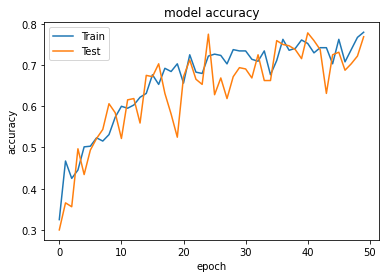

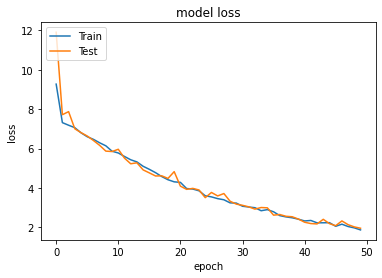

In [ ]:
import matplotlib.pyplot as plt
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import to_categorical
test_images,test_labels = get_images('/content/seg_test/seg_test/')

test_label = to_categorical(test_labels)
test_images = np.array(test_images)
test_labels = np.array(test_label)

vgg_16_model.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 7s 72ms/step - loss: 2.2965 - accuracy: 0.6460


[2.2964885234832764, 0.6460000276565552]

In [ ]:
pred_images,no_labels = get_images('/content/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


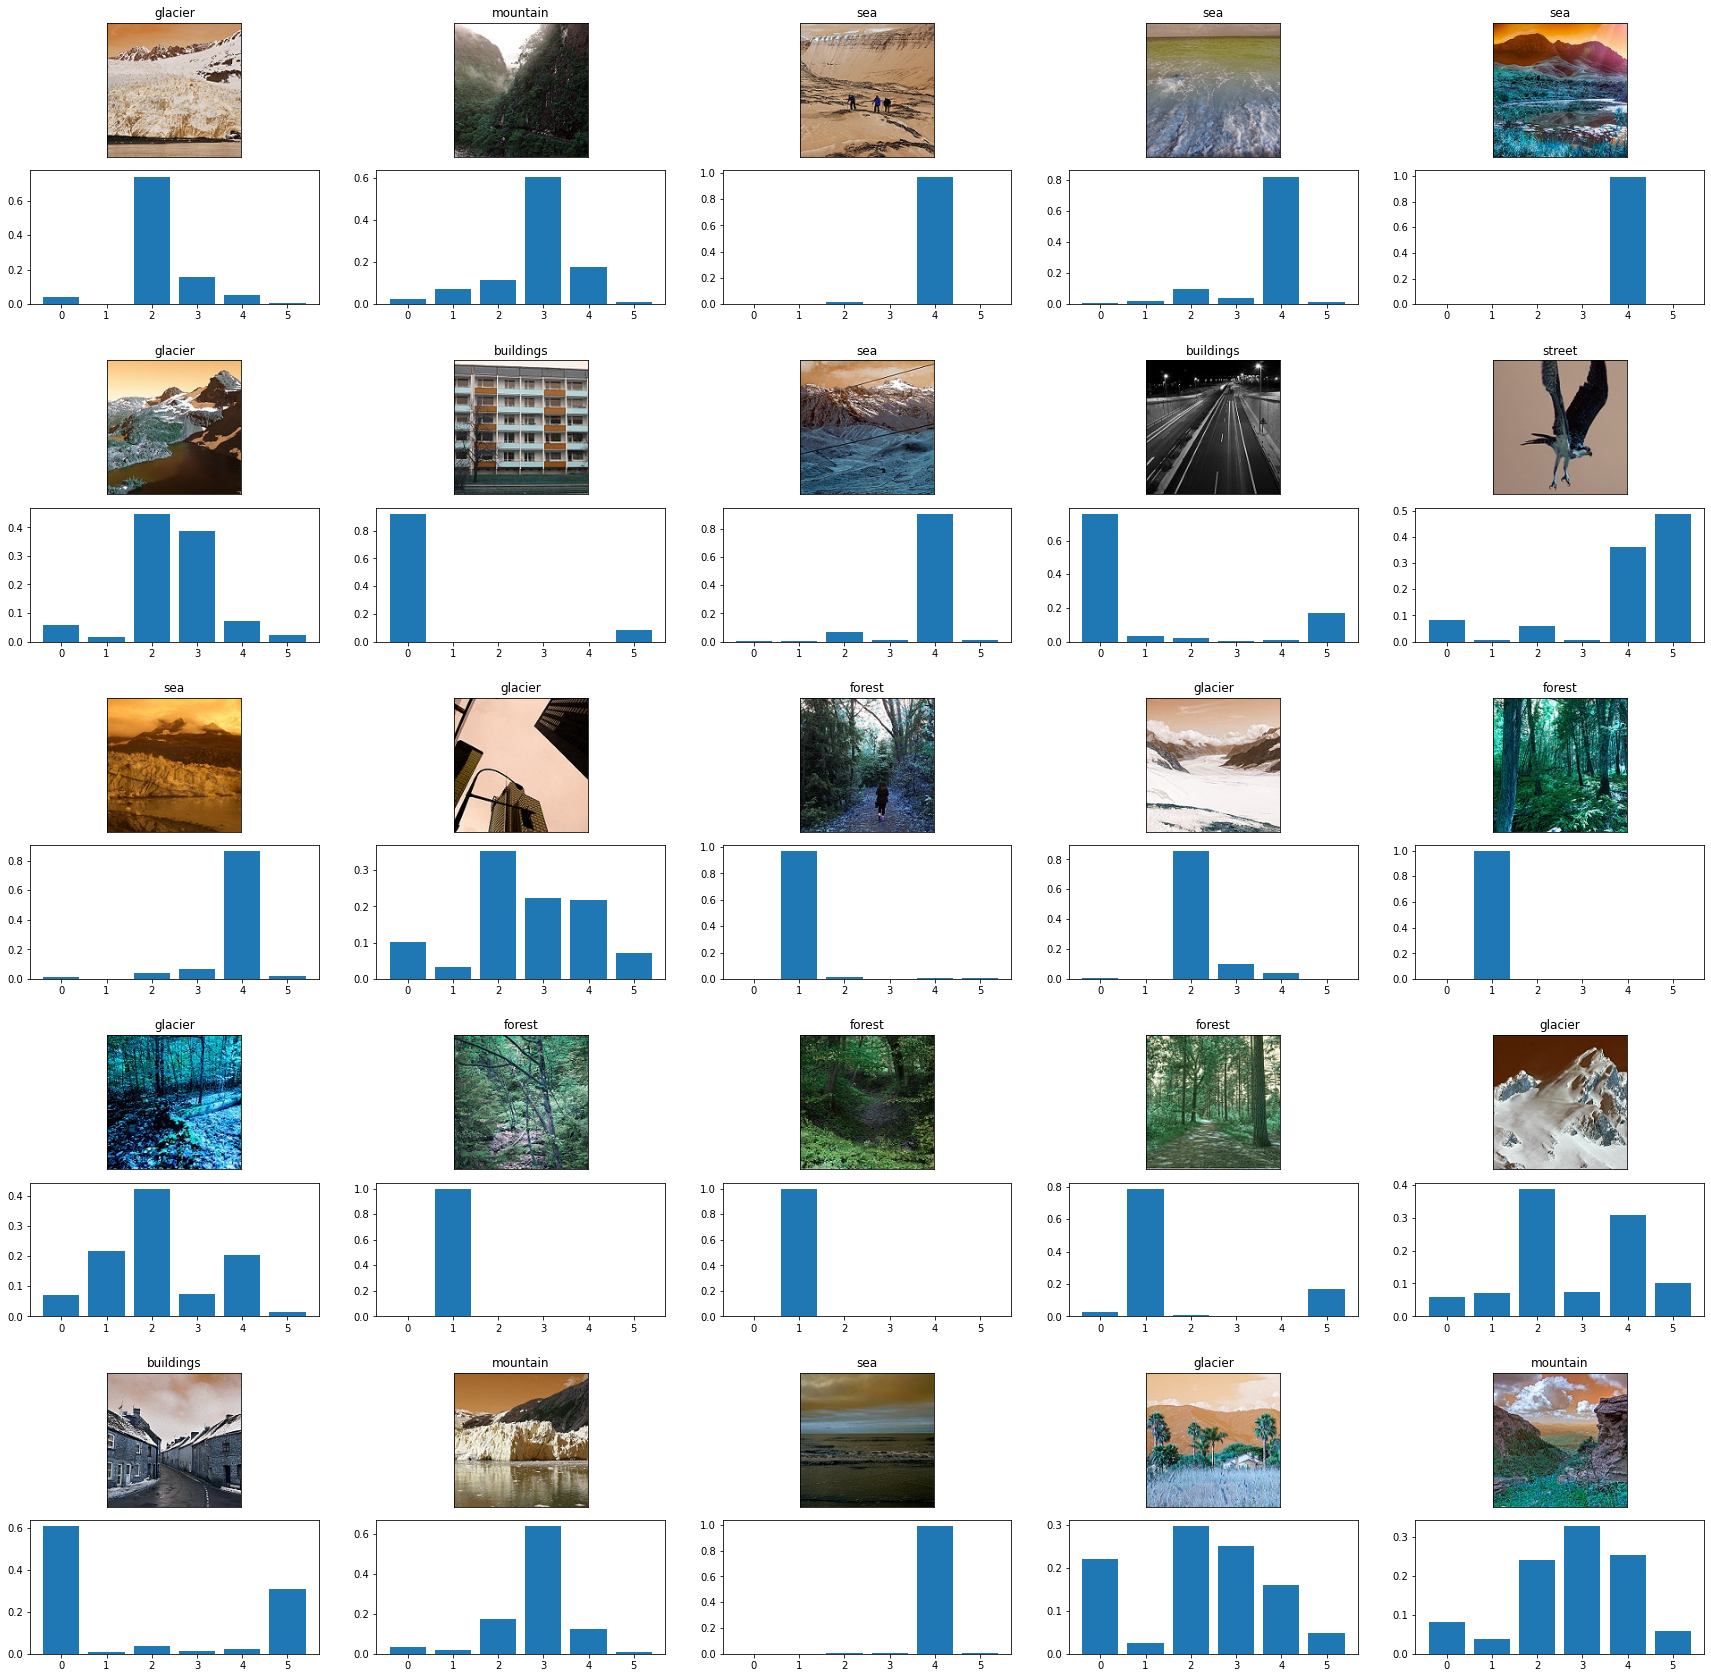

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(vgg_16_model.predict_classes(pred_image)[0])
    pred_prob = vgg_16_model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()